In [165]:
try:
    import matplotlib.pyplot as plt
    from datasets import load_dataset
    from comet_ml import start
    import numpy as np
    import umap
    import torch
    import torch.nn as nn
except:
    import os
    os.system("pip install datasets comet_ml umap_learn")

import PIL
import pandas as pd

data = load_dataset("Artificio/WikiArt_Full")['train']

sample_size = 1024
genres, styles, image_refs = data['genre'][:sample_size], data['style'][:sample_size], data['image'][:sample_size]

# czytanie zdjec
images = []
for ref in image_refs:
    images.append( np.array(ref) )
images = torch.Tensor( np.array(images) )

mask = torch.zeros_like( torch.Tensor(images.shape[:-1]) ).unsqueeze(3) # pierwsze 3 wymiary takie same tylko ostatni na 1 tak zeby go dodac jako dodatkowy do RGB
images = torch.cat([images, mask], dim=-1) / 255. # maska i normalizacja

In [ ]:
torch.clamp()

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

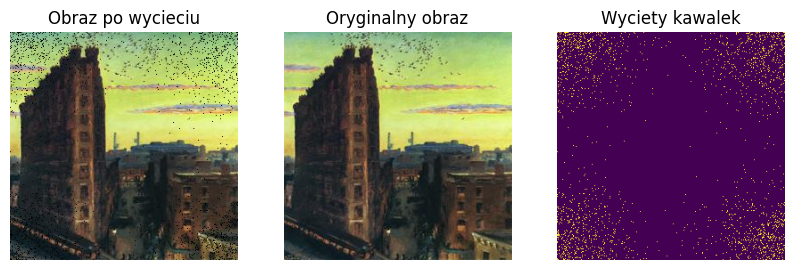

In [433]:
def regular_cut(image):
    image_shape = torch.as_tensor(image.shape[:-1])
    size_to_cut = image_shape // 4
    x_start_cut, y_start_cut = (torch.abs(torch.rand(2)) * (image_shape - size_to_cut)).long() # losowanie indeksow od ktorych zaczac wycinanie
    image_to_ret = image.clone()

    image_to_ret[x_start_cut:x_start_cut+size_to_cut[0], y_start_cut:y_start_cut+size_to_cut[1], :-1] = 0.  # kwadrat wycina
    image_to_ret[x_start_cut:x_start_cut+size_to_cut[0], y_start_cut:y_start_cut+size_to_cut[1], -1] = 1.   # zaznacza gdzie
    return image_to_ret

def irregular_cut(image):
    image_shape = torch.as_tensor(image.shape[:-1])
    size_to_cut = image_shape // 4
    scaling_factor = image_shape[0] // 6
    indxs_to_cut = torch.randn(size_to_cut.tolist()).reshape(-1, 2) * scaling_factor # noralne liczby od 0 do 2 - ish
    indxs_to_cut = torch.clamp(indxs_to_cut, max=image_shape[0] - 1).long() # wyskalowanie do rozmiarow obrazu mniej wiecej i przyciecie

    image_to_ret = image.clone()
    image_to_ret[indxs_to_cut[:, 0], indxs_to_cut[:, 1], :-1] = 0.
    image_to_ret[indxs_to_cut[:, 0], indxs_to_cut[:, 1], -1] = 1.
    return image_to_ret


image_cut = irregular_cut(images[0])
# # # sprawdzenie czy dziala
cut_layer = image_cut[:,:,-1].detach().numpy() # zobaczyc co sie wycielo
image_cut = (image_cut[:,:,:-1].detach().numpy() * 255).astype('uint8') # do numpy'a i skalowanie

fig, ((ax1, ax2, ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(10, 5))

ax1.set_title('Obraz po wycieciu')
ax1.imshow(image_cut)
ax1.axis('off')

ax2.set_title('Oryginalny obraz')
ax2.imshow(np.array(image_refs[0]))
ax2.axis('off')

ax3.set_title('Wyciety kawalek')
ax3.imshow(cut_layer)
ax3.axis('off')

Oryginalny wymiar obrazu 256
Po 1 warstwie encodera rozmiar obrazu: 128
Po 3 warstwie encodera rozmiar obrazu: 64
Po 5 warstwie encodera rozmiar obrazu: 32
Po 7 warstwie encodera rozmiar obrazu: 16
Po 1 warstwie decodera rozmiar obrazu: 32
Po 3 warstwie decodera rozmiar obrazu: 64
Po 5 warstwie decodera rozmiar obrazu: 128
Po 7 warstwie decodera rozmiar obrazu: 256
100.00%

Text(0, 0.5, 'Blad')

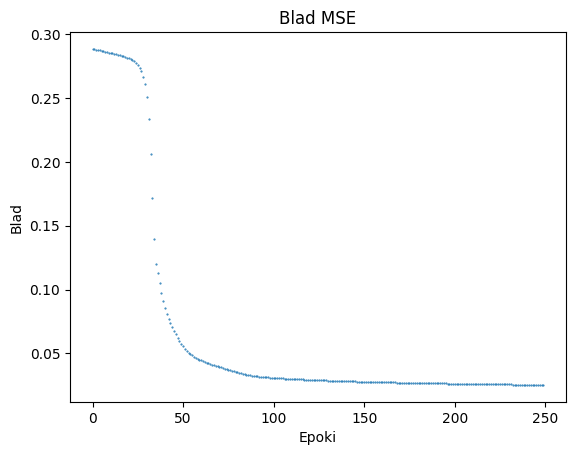

In [90]:
if images.shape[1] != 3: # najpierw powinny isc kanaly na conva
    images = images.permute(0, 3, 1, 2) # N probek, kanaly, wysokosc, szerokosc

class Autoencoder(nn.Module):
    def __init__(self, image_shape, lr):
        super().__init__()
        
        in_channels = image_shape[0]
        kernel = 4
        padding = (kernel - 1) // 2

        self.encode = nn.Sequential(   
            nn.Conv2d(in_channels, 3, kernel_size=kernel, stride=2, padding=padding), nn.ReLU(),
            nn.Conv2d(3, 3, kernel_size=kernel, stride=2, padding=padding), nn.ReLU(),
            nn.Conv2d(3, 3, kernel_size=kernel, stride=2, padding=padding), nn.ReLU(),
            nn.Conv2d(3, 3, kernel_size=kernel, stride=2, padding=padding), nn.ReLU(),
        )
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(3, 3, kernel_size=kernel, stride=2, padding=padding), nn.ReLU(),
            nn.ConvTranspose2d(3, 3, kernel_size=kernel, stride=2, padding=padding), nn.ReLU(),
            nn.ConvTranspose2d(3, 3, kernel_size=kernel, stride=2, padding=padding), nn.ReLU(),
            nn.ConvTranspose2d(3, 3, kernel_size=kernel, stride=2, padding=padding), nn.ReLU(),
        )
        
        # liczenie rozmiarow po convach - 
        w = image_shape[1] # obrazy maja takie same szerokosci i wysokosci
        print(f'Oryginalny wymiar obrazu {w}')
        for i, layer in enumerate(self.encode):
            if isinstance(layer, nn.Conv2d):
                w = (w - layer.kernel_size[0] + 2*layer.padding[0]) // layer.stride[0] + 1
                print(f'Po {i+1} warstwie encodera rozmiar obrazu: {w}')

        for i, layer, in enumerate(self.decode):
            if isinstance(layer, nn.ConvTranspose2d):
                w = (w - 1) * layer.stride[0] + layer.kernel_size[0] - 2*layer.padding[0]
                print(f'Po {i+1} warstwie decodera rozmiar obrazu: {w}')

        self.optim = torch.optim.Adam(self.parameters(), lr)
        self.loss = nn.MSELoss()

    def forward(self, input):
        return self.decode( self.encode(input) )
    
ENCODER_EPOCHS = 250
BATCH_SIZE = 128
autoencoder = Autoencoder(images.shape[1:], 1e-4)
loss_history = np.zeros(ENCODER_EPOCHS)

if torch.cuda.is_available():
    images = images.to('cuda')
    autoencoder = autoencoder.to('cuda')

# trenowanie encodera
for epoch in range(ENCODER_EPOCHS):
    print(f'\r{epoch / (ENCODER_EPOCHS - 1) * 100:.2f}%', end='', flush=True)
    for i in range(int(images.shape[0] / BATCH_SIZE)): # TODO na dataLoaderze to zrobic
        batch = images[i * BATCH_SIZE: (i+1) * BATCH_SIZE, :, : ,: ]
        autoencoder.zero_grad()
        image_reconstructed = autoencoder(batch)
        loss = autoencoder.loss(batch, image_reconstructed)
        loss.backward()
        autoencoder.optim.step()
        
        loss_history[epoch] = loss.item()

plt.title('Blad MSE')
plt.plot(loss_history, 'o', markersize=0.5)
plt.xlabel('Epoki')
plt.ylabel('Blad')

TypeError: tuple indices must be integers or slices, not tuple